# WTTE-RNN in keras ( standalone )
A template to use with data of varying shape (but fixed sequence length for now).

This notebook is written to be as explicit as possible, hope you can follow. Everything is inlined so it has no dependencies with the rest of the repo and I have no plan to keep it updated but PRs are welcome. See See `simple_example.ipynb` for an updated example.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import theano as T
from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM,GRU
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam
from keras.callbacks import History, TensorBoard

print('tensorflow version '+tf.__version__) 
#print('theano     version '+T.__version__) 

Using TensorFlow backend.


tensorflow version 1.3.0


In [2]:
def _keras_unstack_hack(ab):
    """Implements tf.unstack(y_true_keras, num=2, axis=-1).
       Keras-hack adopted to be compatible with theano backend.
    """
    ndim = len(K.int_shape(ab))
    if ndim == 0:
        print('can not unstack with ndim=0')
    else:
        a = ab[..., 0]
        b = ab[..., 1]
    return a, b

def weibull_loss_discrete(y_true, y_pred, name=None):
    """calculates a keras loss op designed for the sequential api.
    
        Discrete log-likelihood for Weibull hazard function on censored survival data.
        For math, see 
        https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
        
        Args:
            y_true: tensor with last dimension having length 2
                with y_true[:,...,0] = time to event, 
                     y_true[:,...,1] = indicator of not censored
                
            y_pred: tensor with last dimension having length 2 
                with y_pred[:,...,0] = alpha, 
                     y_pred[:,...,1] = beta

        Returns:
            A positive `Tensor` of same shape as input
            
    """    
    y,u = _keras_unstack_hack(y_true)
    a,b = _keras_unstack_hack(y_pred)

    hazard0 = K.pow((y + 1e-35) / a, b)
    hazard1 = K.pow((y + 1.0) / a, b)
    
    loglikelihoods = u * K.log(K.exp(hazard1 - hazard0) - 1.0) - hazard1
    loss = -1 * K.mean(loglikelihoods)
    return loss


def output_lambda(x, init_alpha=1.0, max_beta_value=5.0, max_alpha_value=None):
    """Elementwise (Lambda) computation of alpha and regularized beta.

        Alpha: 
        (activation) 
        Exponential units seems to give faster training than 
        the original papers softplus units. Makes sense due to logarithmic
        effect of change in alpha. 
        (initialization) 
        To get faster training and fewer exploding gradients,
        initialize alpha to be around its scale when beta is around 1.0,
        approx the expected value/mean of training tte. 
        Because we're lazy we want the correct scale of output built
        into the model so initialize implicitly; 
        multiply assumed exp(0)=1 by scale factor `init_alpha`.

        Beta: 
        (activation) 
        We want slow changes when beta-> 0 so Softplus made sense in the original 
        paper but we get similar effect with sigmoid. It also has nice features.
        (regularization) Use max_beta_value to implicitly regularize the model
        (initialization) Fixed to begin moving slowly around 1.0

        Assumes tensorflow backend.

        Args:
            x: tensor with last dimension having length 2
                with x[...,0] = alpha, x[...,1] = beta

        Usage:
            model.add(Dense(2))
            model.add(Lambda(output_lambda, arguments={"init_alpha":100., "max_beta_value":2.0}))
        Returns:
            A positive `Tensor` of same shape as input
    """
    a, b = _keras_unstack_hack(x)

    # Implicitly initialize alpha:
    if max_alpha_value is None:
        a = init_alpha * K.exp(a)
    else:
        a = init_alpha * K.clip(x=a, min_value=K.epsilon(),
                                max_value=max_alpha_value)

    m = max_beta_value
    if m > 1.05:  # some value >>1.0
        # shift to start around 1.0
        # assuming input is around 0.0
        _shift = np.log(m - 1.0)

        b = K.sigmoid(b - _shift)
    else:
        b = K.sigmoid(b)

    # Clipped sigmoid : has zero gradient at 0,1
    # Reduces the small tendency of instability after long training
    # by zeroing gradient.
    b = m * K.clip(x=b, min_value=K.epsilon(), max_value=1. - K.epsilon())

    x = K.stack([a, b], axis=-1)

    return x


## Generate evenly spaced sequences with noisy measurements

In [3]:
def get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored = True):
    def get_equal_spaced(n, every_nth):
        # create some simple data of evenly spaced events recurring every_nth step
        # Each is on (time,batch)-format
        events = np.array([np.array(range(n)) for _ in range(every_nth)])
        events = events + np.array(range(every_nth)).reshape(every_nth, 1) + 1

        tte_actual = every_nth - 1 - events % every_nth

        was_event = (events % every_nth == 0) * 1.0
        was_event[:, 0] = 0.0

        events = tte_actual == 0

        is_censored = (events[:, ::-1].cumsum(1)[:, ::-1] == 0) * 1
        tte_censored = is_censored[:, ::-1].cumsum(1)[:, ::-1] * is_censored
        tte_censored = tte_censored + (1 - is_censored) * tte_actual

        events = np.copy(events.T * 1.0)
        tte_actual = np.copy(tte_actual.T * 1.0)
        tte_censored = np.copy(tte_censored.T * 1.0)
        was_event = np.copy(was_event.T * 1.0)
        not_censored = 1 - np.copy(is_censored.T * 1.0)

        return tte_censored, not_censored, was_event, events, tte_actual
    
    tte_censored,not_censored,was_event,events,tte_actual = get_equal_spaced(n=n_timesteps,every_nth=every_nth)

    # From https://keras.io/layers/recurrent/
    # input shape rnn recurrent if return_sequences: (nb_samples, timesteps, input_dim)

    u_train      = not_censored.T.reshape(n_sequences,n_timesteps,1)
    x_train      = was_event.T.reshape(n_sequences,n_timesteps,1)
    tte_censored = tte_censored.T.reshape(n_sequences,n_timesteps,1)
    y_train      = np.append(tte_censored,u_train,axis=2) # (n_sequences,n_timesteps,2)

    u_test       = np.ones(shape=(n_sequences,n_timesteps,1))
    x_test       = np.copy(x_train)
    tte_actual   = tte_actual.T.reshape(n_sequences,n_timesteps,1)
    y_test       = np.append(tte_actual,u_test,axis=2) # (n_sequences,n_timesteps,2)

    if not use_censored:
        x_train = np.copy(x_test)
        y_train = np.copy(y_test)
    # Since the above is deterministic perfect fit is feasible. 
    # More noise->more fun so add noise to the training data:
    
    x_train = np.tile(x_train.T,n_repeats).T
    y_train = np.tile(y_train.T,n_repeats).T

    # Try with more than one feature TODO
    x_train_new = np.zeros([x_train.shape[0],x_train.shape[1],n_features])
    x_test_new = np.zeros([x_test.shape[0],x_test.shape[1],n_features])
    for f in range(n_features):
        x_train_new[:,:,f] = x_train[:,:,0]
        x_test_new[:,:,f]  = x_test[:,:,0]
        
    x_train = x_train_new
    x_test  = x_test_new
    
    # xtrain is signal XOR noise with probability noise_level
    noise = np.random.binomial(1,noise_level,size=x_train.shape)
    x_train = x_train+noise-x_train*noise
    return y_train,x_train, y_test,x_test,events


test shape (80, 200, 2) (80, 200, 1)


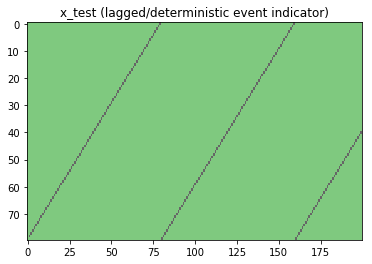

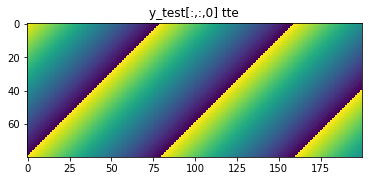

train shape (80000, 200, 2) (80000, 200, 1)


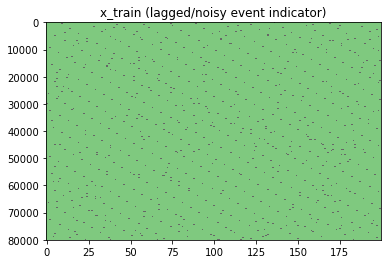

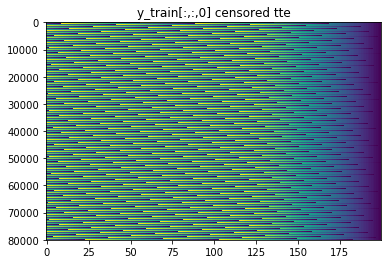

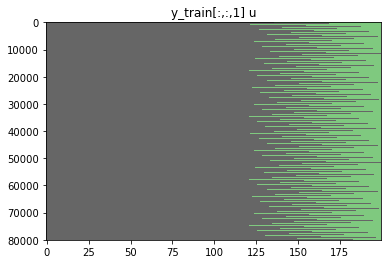

In [4]:
n_timesteps    = 200
n_sequences = every_nth = 80
n_features = 1
n_repeats = 1000
noise_level = 0.005
use_censored = True

y_train,x_train, y_test,x_test,events = get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored)

print('test shape',y_test.shape,x_test.shape)
plt.imshow(x_test[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_test (lagged/deterministic event indicator)')
plt.show()
plt.imshow(y_test[:,:,0],interpolation="none")
plt.title('y_test[:,:,0] tte')
plt.show()

print('train shape',y_train.shape,x_train.shape)
# (might look like the pattern is different but set n_repeats 
#  lower and you'll see that it's the same):
plt.imshow(x_train[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_train (lagged/noisy event indicator)')
plt.show()
plt.imshow(y_train[:,:,0],interpolation="none",aspect='auto')
plt.title('y_train[:,:,0] censored tte')
plt.show()
plt.imshow(y_train[:,:,1],interpolation="none",cmap='Accent',aspect='auto')
plt.title('y_train[:,:,1] u')
plt.show()


### To test your implementation, feed raw weibull data
Uncomment and run cell below

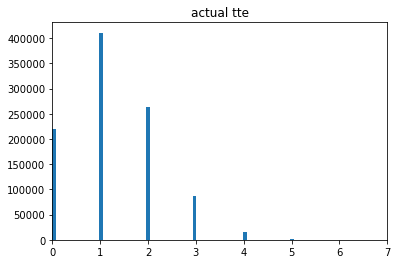

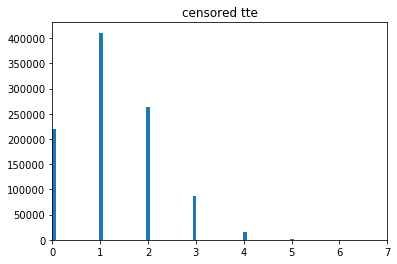

(10000, 100, 2)
(10000, 100, 2)


In [5]:
# ## SANITY CHECK: Use pure Weibull data censored at C(ensoring point). 
# ## Should converge to the generating A(alpha) and B(eta) for each timestep
def generate_data(A,B,C,shape,discrete_time):
     # Generate Weibull random variables
     W = np.sort(A*np.power(-np.log(np.random.uniform(0,1,shape)),1/B))
    
     if discrete_time:
         C = np.floor(C)
         W = np.floor(W)

     U = np.less_equal(W, C)*1
     Y = np.minimum(W,C)    
     return W,Y,U

n_sequences = 10000
n_timesteps = 100
n_features = 1

y_test,y_train,u_train = generate_data(A=2.,
                                        B=2.,
                                        C=np.Inf, # <np.inf -> impose censoring
                                        shape=[n_sequences,n_timesteps,n_features],
                                        discrete_time=True)
x_train = x_test = np.ones_like(y_train)

y_test   = np.append(y_test,np.ones_like(y_test),axis=-1)
y_train  = np.append(y_train,u_train,axis=-1)

xlim_temp = y_test[:,:,0].max()
plt.hist(y_test[:,:,0].flatten(),bins=100)
plt.xlim(0,xlim_temp)
plt.title('actual tte')
plt.show()
plt.hist(y_train[:,:,0].flatten(),bins=100)
plt.title('censored tte')
plt.xlim(0,xlim_temp)
plt.show()
print(y_test.shape)
print(y_train.shape)

In [6]:
# Prep. output activation layer.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(y_train[:,:,0])
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/np.nanmean(y_train[:,:,1]) # use if lots of censoring
print('init_alpha: ',init_alpha)

np.random.seed(1)
# Store some history
history = History()

# Start building the model
model = Sequential()
#model.add(TimeDistributed(Dense(2), input_shape=(None, n_features)))
model.add(GRU(1, input_shape=(n_timesteps, n_features),activation='tanh',return_sequences=True))

model.add(Dense(2))
model.add(Lambda(output_lambda, arguments={"init_alpha":init_alpha, 
                                               "max_beta_value":4.0}))

model.compile(loss=weibull_loss_discrete, optimizer=adam(lr=.01))

model.summary()

init_alpha:  1.72545169391
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100, 1)            9         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 2)            4         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 2)            0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Fit! (really don't need to train this long)
np.random.seed(1)
model.fit(x_train, y_train,
          epochs=40, 
          batch_size=x_train.shape[0]//10, 
          verbose=2, 
          validation_data=(x_test, y_test),
          callbacks=[history]
          )

Train on 10000 samples, validate on 10000 samples
Epoch 1/40
1s - loss: 1.3427 - val_loss: 1.3426
Epoch 2/40
1s - loss: 1.3427 - val_loss: 1.3426
Epoch 3/40
1s - loss: 1.3427 - val_loss: 1.3426
Epoch 4/40
1s - loss: 1.3427 - val_loss: 1.3427
Epoch 5/40
1s - loss: 1.3427 - val_loss: 1.3427
Epoch 6/40
1s - loss: 1.3426 - val_loss: 1.3426
Epoch 7/40
1s - loss: 1.3427 - val_loss: 1.3426
Epoch 8/40
1s - loss: 1.3427 - val_loss: 1.3425
Epoch 9/40
1s - loss: 1.3427 - val_loss: 1.3426
Epoch 10/40
1s - loss: 1.3427 - val_loss: 1.3427
Epoch 11/40
1s - loss: 1.3428 - val_loss: 1.3426
Epoch 12/40
1s - loss: 1.3427 - val_loss: 1.3427
Epoch 13/40
1s - loss: 1.3427 - val_loss: 1.3430
Epoch 14/40
1s - loss: 1.3427 - val_loss: 1.3428
Epoch 15/40
1s - loss: 1.3427 - val_loss: 1.3427
Epoch 16/40
1s - loss: 1.3427 - val_loss: 1.3428
Epoch 17/40
2s - loss: 1.3427 - val_loss: 1.3427
Epoch 18/40
1s - loss: 1.3427 - val_loss: 1.3429
Epoch 19/40
1s - loss: 1.3428 - val_loss: 1.3427
Epoch 20/40
1s - loss: 1.342

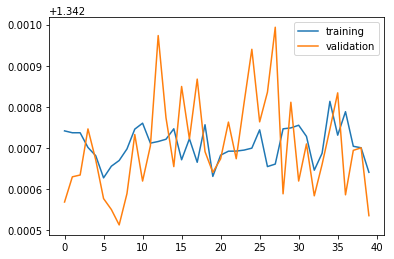

In [12]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

# Predictions
Try out training the model with different levels of noise. With more noise confidence gets lower (smaller beta). With less noise beta goes to maximum value and the predicted mode/peak probability is centered around the actual TTE.

In [ ]:
# Make some parametric predictions
print 'All test cases (no noise)'
print '(each horizontal line is a sequence)'
predicted = model.predict(x_test)
plt.imshow(x_test[:every_nth,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent')
plt.title('x features')
plt.show()
print(predicted.shape)
plt.imshow(predicted[:,:,0],interpolation="none")
plt.title('alpha')
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none")
plt.title('beta')
plt.show()

print 'Some training cases (noisy features)'
predicted = model.predict(x_train[:every_nth,:,:])
print(predicted.shape)
plt.imshow(x_train[:every_nth,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent')
plt.title('x features')
plt.show()
plt.imshow(predicted[:,:,0],interpolation="none")
plt.title('alpha')
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none")
plt.title('beta')
plt.show()


In [ ]:
def weibull_quantiles(a, b, p):
    return a*np.power(-np.log(1.0-p),1.0/b)

def weibull_mode(a, b):
    # Continuous mode. 
    # TODO (mathematically) prove how close it is to discretized mode
    mode = a*np.power((b-1.0)/b,1.0/b)
    mode[b<=1.0]=0.0
    return mode

def weibull_mean(a, b):
    # Continuous mean. Theoretically at most 1 step below discretized mean 
    # E[T ] <= E[Td] + 1 true for positive distributions. 
    from scipy.special import gamma
    return a*gamma(1.0+1.0/b)

# TTE, Event Indicator, Alpha, Beta
drawstyle = 'steps-post'

print 'one training case:'
batch_indx =every_nth/2
a = predicted[batch_indx,:,0]
b = predicted[batch_indx,:,1]
this_x_train = x_train[batch_indx,:,:].mean(axis=1)
this_x_test =  x_test[batch_indx,:,:].mean(axis=1)

this_tte_train = y_train[batch_indx,:,0]
this_tte_test =  y_test[batch_indx,:,0]

plt.plot(a,drawstyle='steps-post')
plt.title('predicted alpha')
plt.show()
plt.plot(b,drawstyle='steps-post')
plt.title('predicted beta')
plt.show()

plt.bar(xrange(n_timesteps),this_x_test,color='black', label='lagged event')
plt.bar(xrange(n_timesteps),this_x_train,color='red',linewidth=0,label='mean feature input')
plt.title('event')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(this_tte_test ,label='actual tte',color='black',linewidth=2,drawstyle=drawstyle)
plt.plot(this_tte_train,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)

plt.plot(weibull_quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
plt.plot(weibull_mode(a, b), color='red',linewidth=2,label='pred mode/peak prob',drawstyle=drawstyle)
#plt.plot(weibull_mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
plt.plot(weibull_quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)
plt.xlabel('time')
plt.ylabel('time to event')
plt.bar(xrange(n_timesteps),this_x_train,color='red',label='mean feature input')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()